# Loading the Dataset

In [ ]:
import requests
import os
import zipfile
import io

def download_kaggle_dataset(username, key, dataset, download_path='.'):
    base_url = f"https://www.kaggle.com/api/v1/datasets/download/{dataset}"
    auth = (username, key)

    response = requests.get(base_url, auth=auth, stream=True)
    if response.status_code == 200:
        print("Loading Dataset...")
        z = zipfile.ZipFile(io.BytesIO(response.content))
        z.extractall(download_path)
        print("Dataset downloaded.")
    else:
        print(f"Error loading dataset: {response.status_code} - {response.text}")

username = "carlosramrezsalas"
key = "9be16033ffab503a1fb76b570900e67d"
dataset = 'gpiosenka/cards-image-datasetclassification'  # Reemplaza con el identificador del dataset que necesitas


download_kaggle_dataset(username, key, dataset)



Descargando el dataset...
Dataset descargado y descomprimido con éxito.


# Function to read and resize the image

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
def read_and_get_image(image_path, size=(128, 128)):
    image_data = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_data)
    gray_image = tf.image.rgb_to_grayscale(image)
    resized_image = tf.image.resize(gray_image, size)
    resized_image = resized_image.numpy()

    return resized_image

# Geting the train and test data

In [ ]:
import pandas as pd

df = pd.read_csv('cards.csv')
train_df = df[df["data set"] == "train"]
test_df = df[df["data set"] == "test"]


# getting the all the images into a numpy array

In [ ]:
import numpy as np
train_images  = []
test_images = []
labels = []
dict_labels = {}
max_index = df['class index'].max() - 1
for index in range(max_index):
  df_class = df[(df['class index'] == index) & (df['data set'] == "train")]
  df_test = df[(df['class index'] == index) & (df['data set'] == "test")]
  names = df_class['labels'].unique()
  dict_labels[index] = names
  for file_path in df_class['filepaths']:
    r = "/content/" + file_path
    if tf.io.gfile.exists(r):
        train_images.append(read_and_get_image(r))
        labels.append(index)
    else:
        print(f"Warning: File not found: {r}")
  for file_path in df_test['filepaths']:
    r = "/content/" + file_path
    if tf.io.gfile.exists(r):
        test_images.append(read_and_get_image(r))
    else:
        print(f"Warning: File not found: {r}")

train_images = np.stack(train_images)
train_images = np.squeeze(train_images)
test_images = np.stack(test_images)
labels = np.array(labels)
test_images = np.squeeze(test_images)
print(train_images.shape)

(7314, 128, 128)


In [ ]:
print(len(labels))
print(train_images.shape)

7314
(7314, 128, 128)


In [ ]:
def show_image(image, class_name):
    plt.imshow(image, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
    plt.show()

# Showing one image

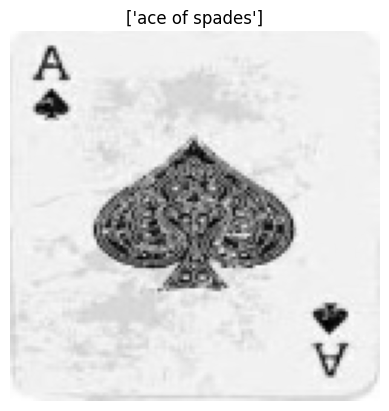

In [ ]:
show_image(train_images[600],dict_labels[labels[600]])

# Model architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(51, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, labels, epochs=10)

Epoch 1/10
229/229 [==============================] - 10s 20ms/step - loss: 4.0312 - accuracy: 0.1116
Epoch 2/10
229/229 [==============================] - 4s 17ms/step - loss: 2.1449 - accuracy: 0.4274
Epoch 3/10
229/229 [==============================] - 4s 16ms/step - loss: 1.5649 - accuracy: 0.5849
Epoch 4/10
229/229 [==============================] - 4s 16ms/step - loss: 1.2060 - accuracy: 0.6650
Epoch 5/10
229/229 [==============================] - 4s 17ms/step - loss: 0.8952 - accuracy: 0.7492
Epoch 6/10
229/229 [==============================] - 4s 18ms/step - loss: 0.6443 - accuracy: 0.8191
Epoch 7/10
229/229 [==============================] - 4s 17ms/step - loss: 0.4745 - accuracy: 0.8690
Epoch 8/10
229/229 [==============================] - 4s 17ms/step - loss: 0.3148 - accuracy: 0.9154
Epoch 9/10
229/229 [==============================] - 4s 16ms/step - loss: 0.2611 - accuracy: 0.9325
Epoch 10/10
229/229 [==============================] - 4s 16ms/step - loss: 0.2126 - accur

In [ ]:
p = model.predict(test_images)
p.shape

8/8 [==============================] - 0s 51ms/step


(255, 51)

In [ ]:
p[70].argmax()

14

# Predictions

51
3


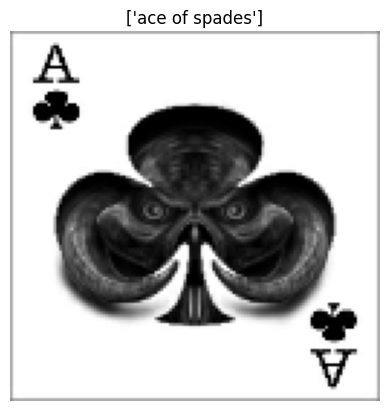

0


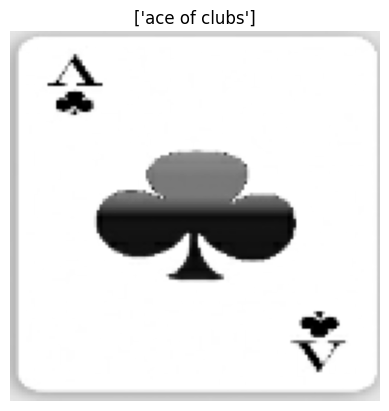

0


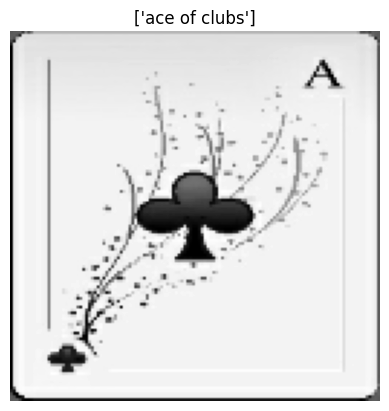

0


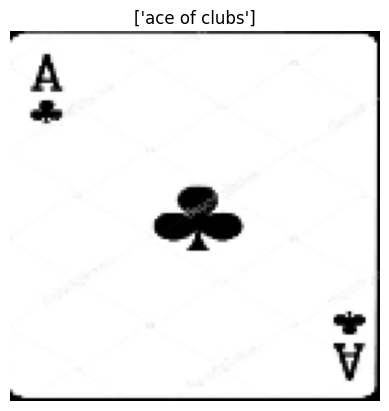

0


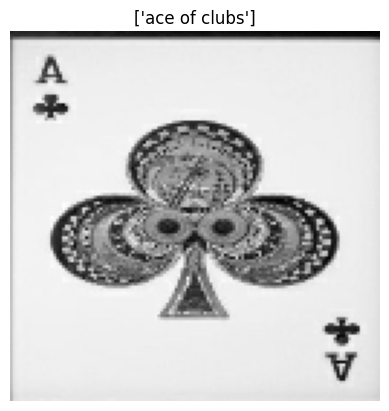

1


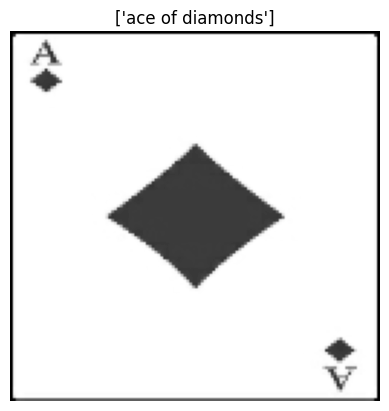

3


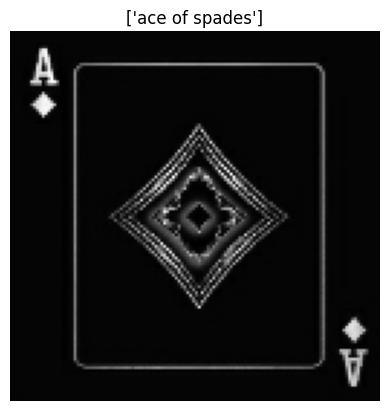

1


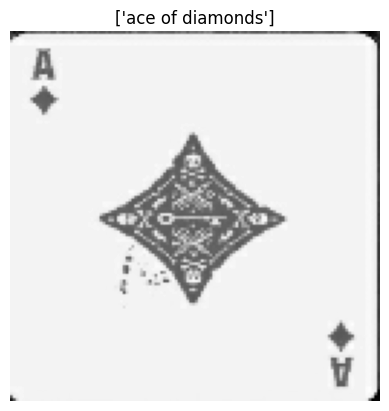

1


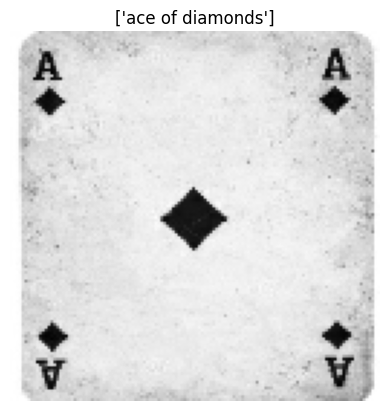

34


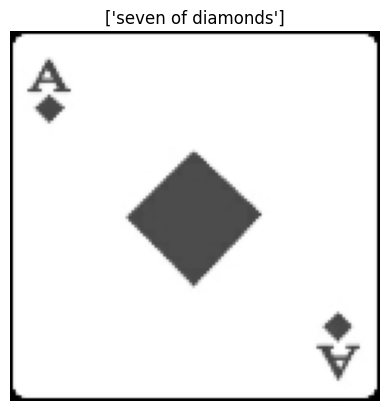

2


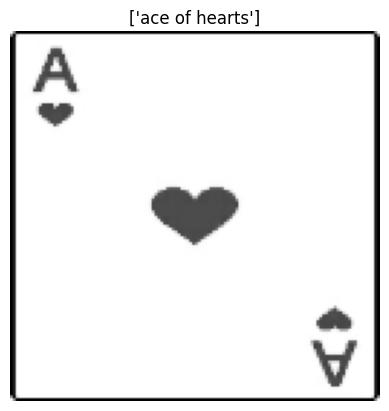

2


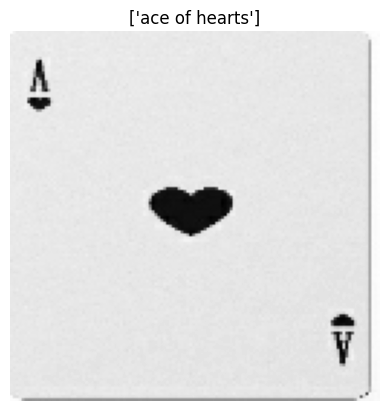

2


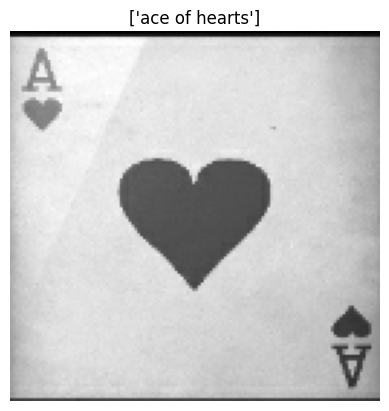

2


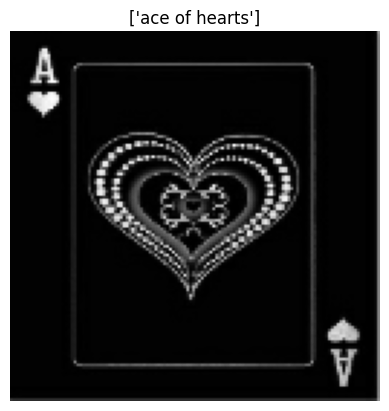

2


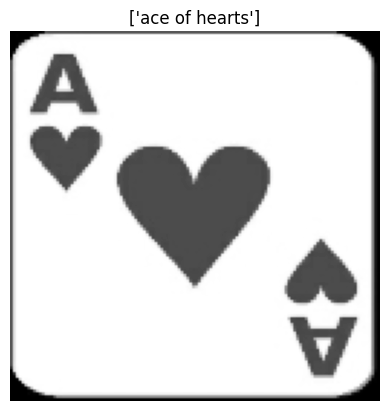

3


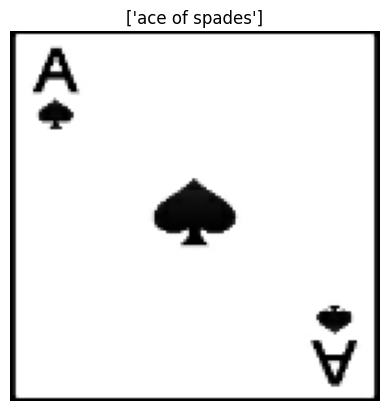

3


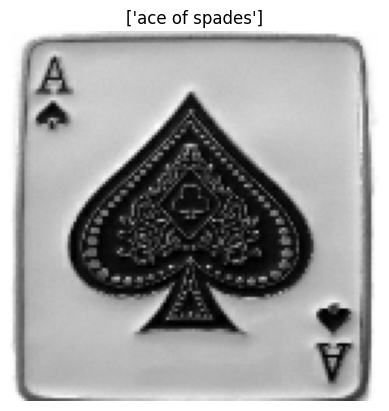

3


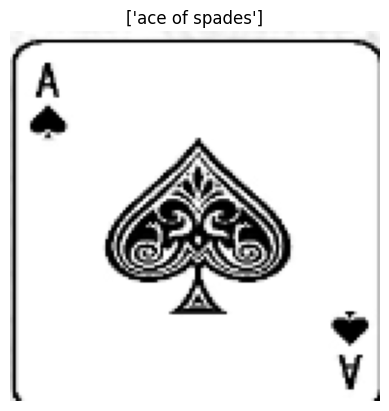

3


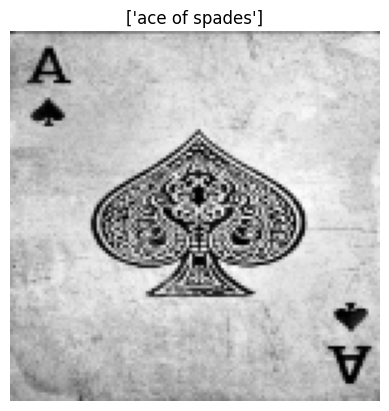

3


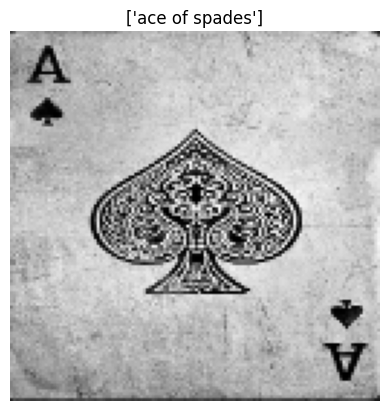

4


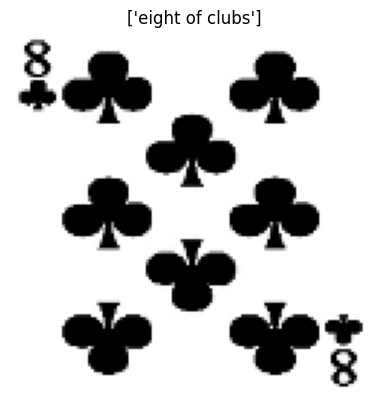

4


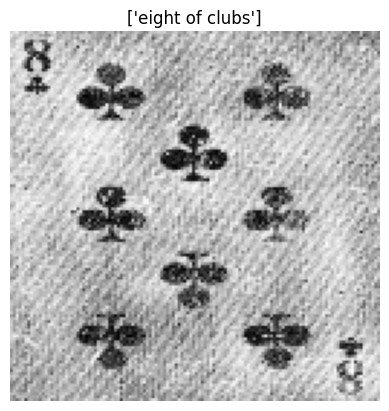

4


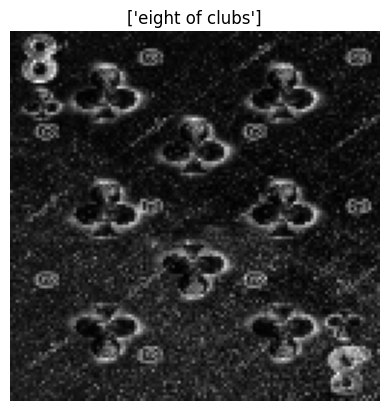

33


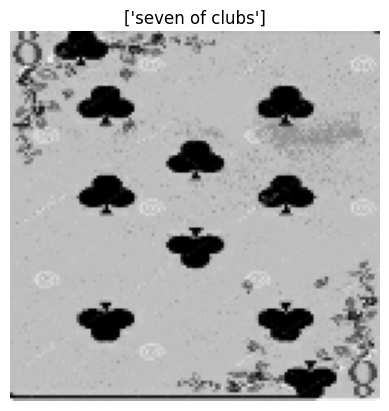

4


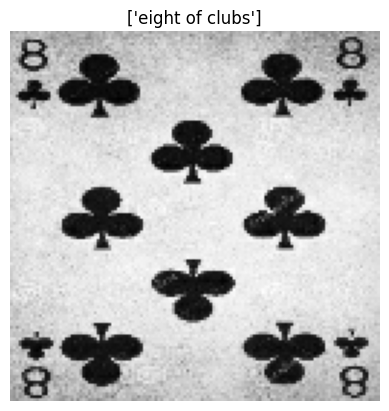

5


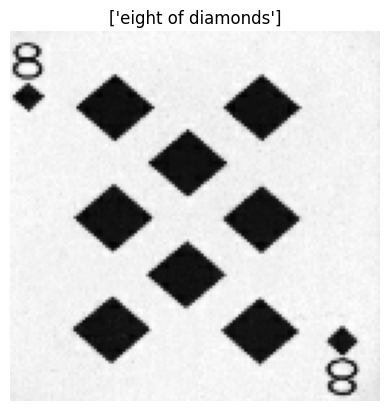

5


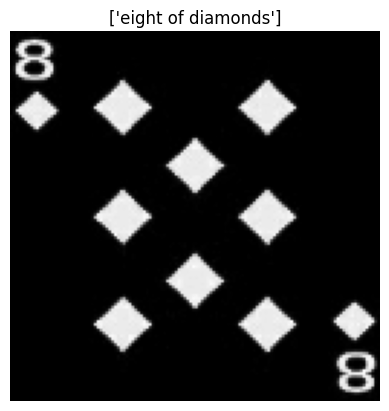

5


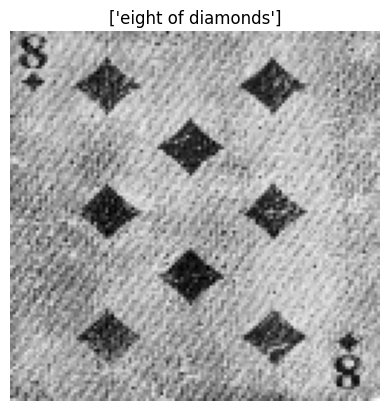

5


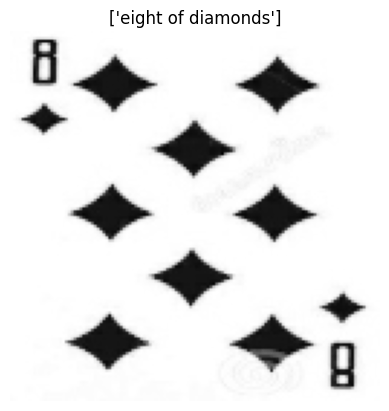

34


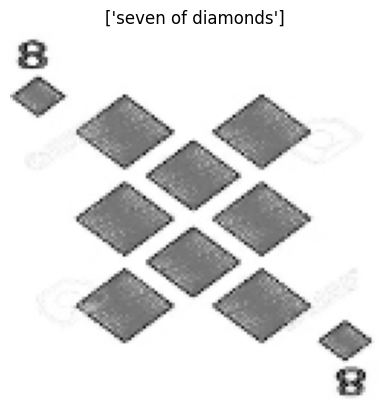

6


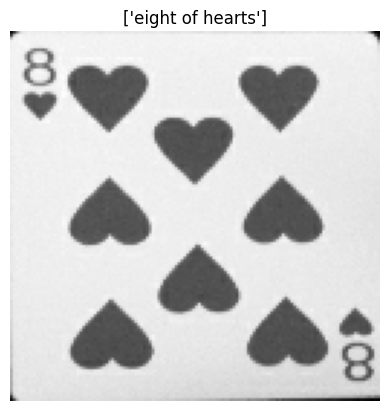

6


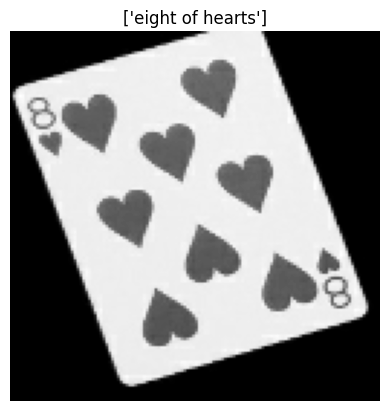

5


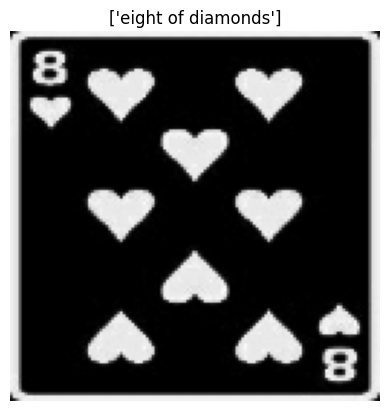

6


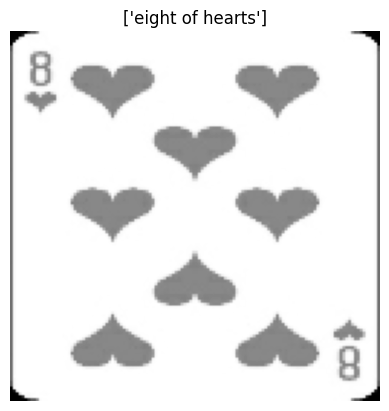

6


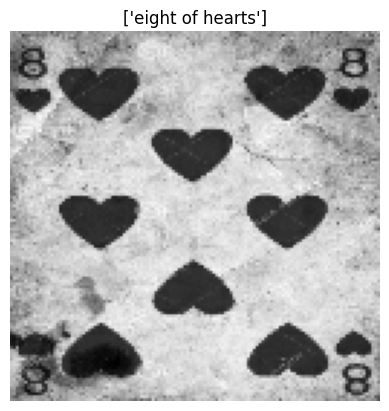

7


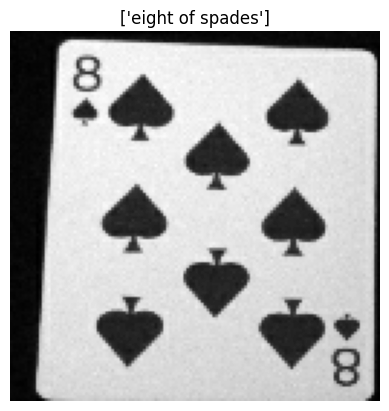

28


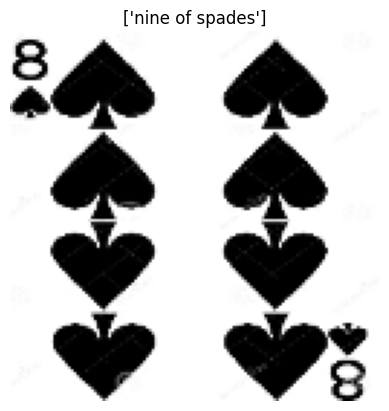

7


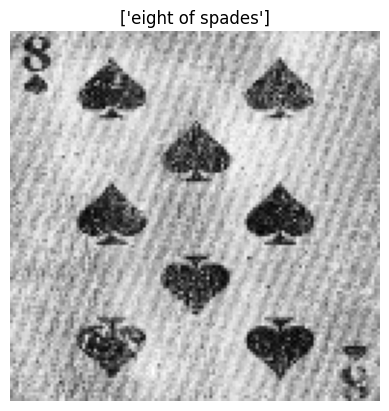

36


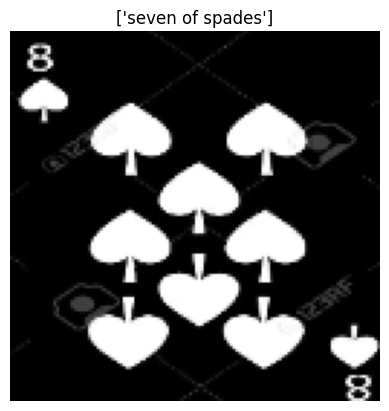

42


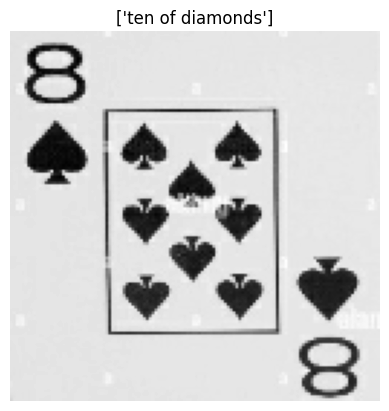

8


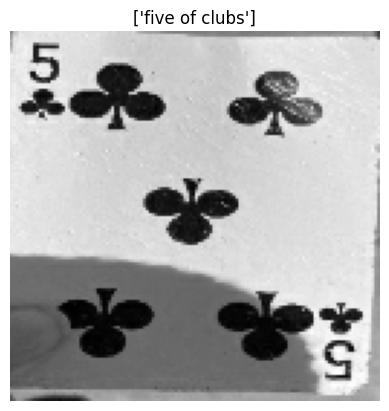

3


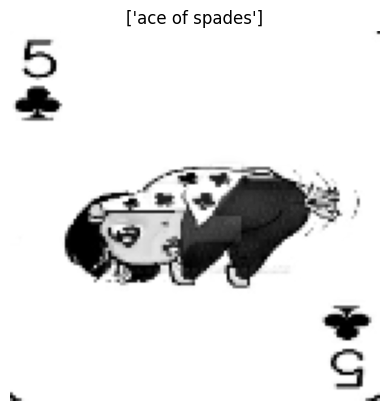

24


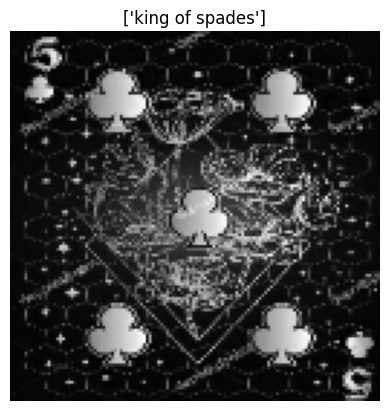

8


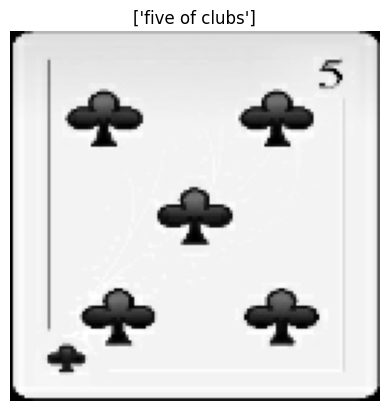

8


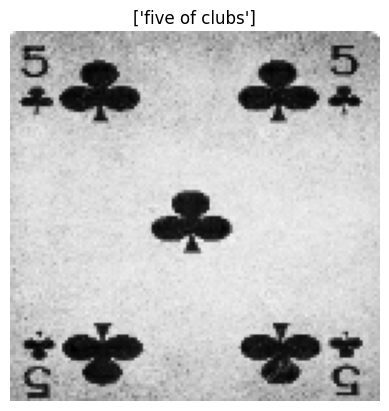

9


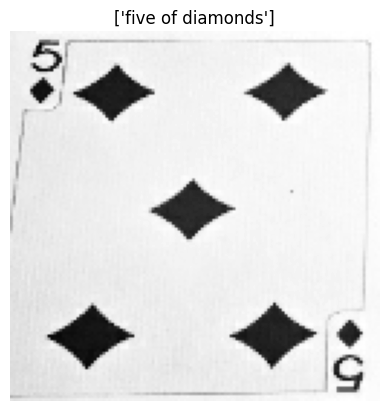

9


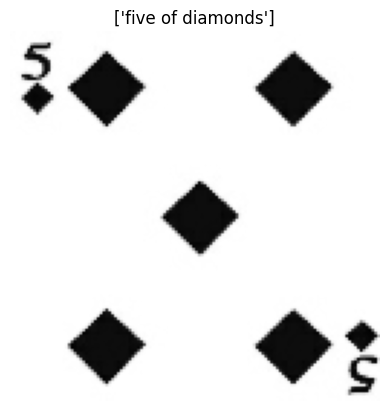

9


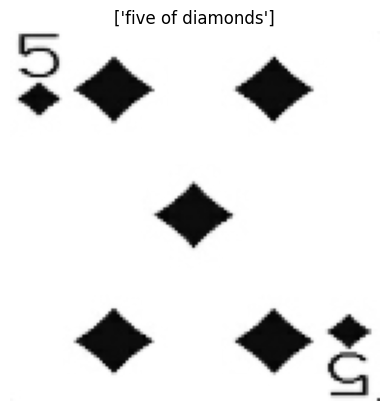

26


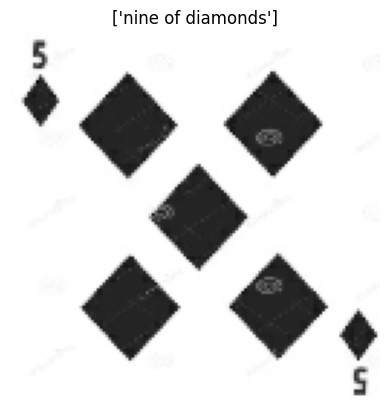

9


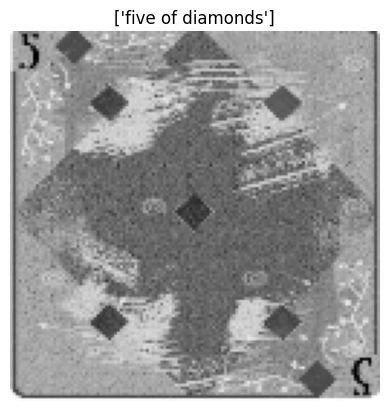

10


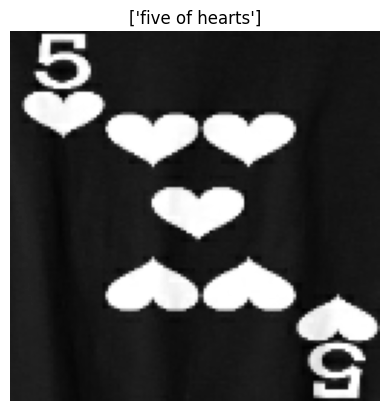

In [ ]:
print(max_index)
for i in range(max_index):
  print(p[i].argmax())
  show_image(test_images[i],dict_labels[p[i].argmax()])